# **`Analysis of Sex-Based Differences in Age of Cardiovascular Disease Patients`**

#### STAT 201 Group Project Proposal ####
##### Group 17 - *Janice Chan, Ena Gupta, Gael Hernandez Palmer*

### Introduction

As it currently stands, cardiovascular disease (CVD) is the second leading cause of death for Canadians (Statistics Canada, 2022). Over years of study, scientists have been able to identify and track certain risk factors for CVD in order to better inform prevention and mitigation efforts. Sex-based differences in both the prevalence and clinical presentation of CVDs have long been a topic of interest with men being afflicted by the disease both more frequently and earlier in their lives (P.H.A of Canada, 2017). The male-focused lens in studying CVDs has historically meant considerable rates of underdiagnosis for women and a misunderstanding of the differences in presentation of disease. 

In this project, our aim is to use compiled data to quantify the difference in mean age between men and women suffering from CVD and their respective standard deviations. To achieve this we will be using the “Heart Disease Data Set” published on the UCI Machine Learning Repository by David Aha. We have selected the Cleveland Clinic database as opposed to the European databases to obtain results that can be generalized to the greater Canadian public based on similar lifestyle and socio-economic distributions between the United States and Canada (Solé-Auro et al., 2017). Our initial report will focus on obtaining summary statistics and visualizations that can help us perform a well-informed analysis using inferential tools as a guide. Age is just one general trait that we can examine between CVD patients. Further research can enhance understanding the different ways CVD impacts patients between males and females, for example comparing the difference in cholesterol levels between male and female patients.

### Dataset:

https://archive.ics.uci.edu/ml/datasets/Heart+Disease

By: David W. Aha

### Preliminary Results

In [12]:
# Load packages
library(digest)
library(infer)
library(repr)
library(tidyverse)
library(dplyr)
library(ggplot2)

In [33]:
# set seed for reproducibility
set.seed(1234)

# HEART DISEASE DATA (Compiled)
# load data

heart_disease_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                                 delim = ",",
                                 col_names = FALSE) %>%
    transmute(age = X1, # clean data; renaming
              
              sex = factor(X2) %>%
                  fct_recode(female = "0", # binary -> factors
                             male = "1"),
              
              chest_pain = factor(X3) %>% # Type of chest pain reported
                  fct_recode(typical_angina = "1", # numerical -> factors
                             atypical_angina = "2",
                             nonanginal_pain = "3",
                             asymptomatic = "4"),
              
              resting_bp = X4, # Resting blood pressure (mm/Hg)
              
              cholesterol = X5, # Total cholesterol (mg/dL)
              
              bldsg_over120 = factor(X6) %>% # Indicates wether the patient's blood sugar is over 120 mg/dL
                  fct_recode(no = "0", # binary -> factors
                             yes = "1"),
              
              rest_ecg = factor(X7) %>% # Resting ECG results
                  fct_recode(normal = "0", # numerical -> factors
                             stt_abnormal = "1", 
                             lv_hyptroph = "2"),
              
              max_hr = X8, # Maximum observed heart rate
              
              ex_angina = factor(X9) %>% # Presence of exercise induced angina
                  fct_recode(no = "0", # binary -> factors
                             yes = "1"),
              
              old_peak = X10, # ST depression induced by exercise relative to rest
              
              slope = factor(X11) %>% # Slope of peak exercise ST segment
                  fct_recode(upslope = "1", # numerical -> factors
                             flat = "2",
                             downslope = "3"),
              
              flr_ves = X12, # Number of vessels coloured by fluoroscopy
              
              thalassemia = factor(X13) %>% 
                  fct_recode(normal = "3.0", # numerical -> factors
                             fxd_def = "6.0",
                             rev_def = "7.0"),
              
              disease = factor(X14) %>% # Disease progression
                 fct_recode(no = "0", # numerical -> factors
                            yes = "1",
                            yes = "2", # 1-4 indicate disease progression 
                            yes = "3", # for our analysis we only care about absence/presence of disease
                            yes = "4")) 

## **NOTE**: 
## Code refactoring was done based on provided attribute information which can be accessed at:
## https://raw.githubusercontent.com/Gaelhpalmer/STAT201Project/main/desc.names
              
head(heart_disease_data)


diseased <- heart_disease_data %>%
    filter(disease == "yes") %>% # filter for those diagnosed with heart disease
    select(age, sex) # select relevant attributes

# Heart disease data for diseased male patients
male_diseased = diseased %>%
    filter(sex == "male") # filter for males

print("Diseased Males")
head(male_diseased)

# Heart disease data for diseased female patients
female_diseased = diseased %>%
    filter(sex == "female")  # filter for those females

print("Diseased Females")
head(female_diseased)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,resting_bp,cholesterol,bldsg_over120,rest_ecg,max_hr,ex_angina,old_peak,slope,flr_ves,thalassemia,disease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<fct>,<fct>
63,male,typical_angina,145,233,yes,lv_hyptroph,150,no,2.3,downslope,0.0,fxd_def,no
67,male,asymptomatic,160,286,no,lv_hyptroph,108,yes,1.5,flat,3.0,normal,yes
67,male,asymptomatic,120,229,no,lv_hyptroph,129,yes,2.6,flat,2.0,rev_def,yes
37,male,nonanginal_pain,130,250,no,normal,187,no,3.5,downslope,0.0,normal,no
41,female,atypical_angina,130,204,no,lv_hyptroph,172,no,1.4,upslope,0.0,normal,no
56,male,atypical_angina,120,236,no,normal,178,no,0.8,upslope,0.0,normal,no


[1] "Diseased Males"


age,sex
<dbl>,<fct>
67,male
67,male
63,male
53,male
56,male
48,male


[1] "Diseased Females"


age,sex
<dbl>,<fct>
62,female
65,female
61,female
51,female
62,female
60,female


In [34]:
# summarize data (estimates)

# Instances 
n_total <- nrow(diseased)
n_male <- nrow(male_diseased)
n_female <- nrow(female_diseased)

# Average age in male patients
mean_age_male = mean(male_diseased$age) %>%
    round(digits = 2)


# Standard deviation of age in male patients
sd_age_male = sd(male_diseased$age) %>%
    round(digits = 2)


# Average age in female patients
mean_age_female = mean(female_diseased$age) %>%
    round(digits = 2)


# Standard deviation of age in female patients
sd_age_female = sd(female_diseased$age) %>%
    round(digits = 2)



#### Number of instances of gender:

| Male | Female | Total|
|------|--------|------|
| 114 | 25 | 139|


#### Average age of heart disease patients:
| Male patients      | Female patients |
| ----------- | ----------- |
| 56.09      | 59.08       |

#### Standard deviation of age in heart disease patients:
| Male patients      | Female patients |
| ----------- | ----------- |
| 8.39     | 4.86       |

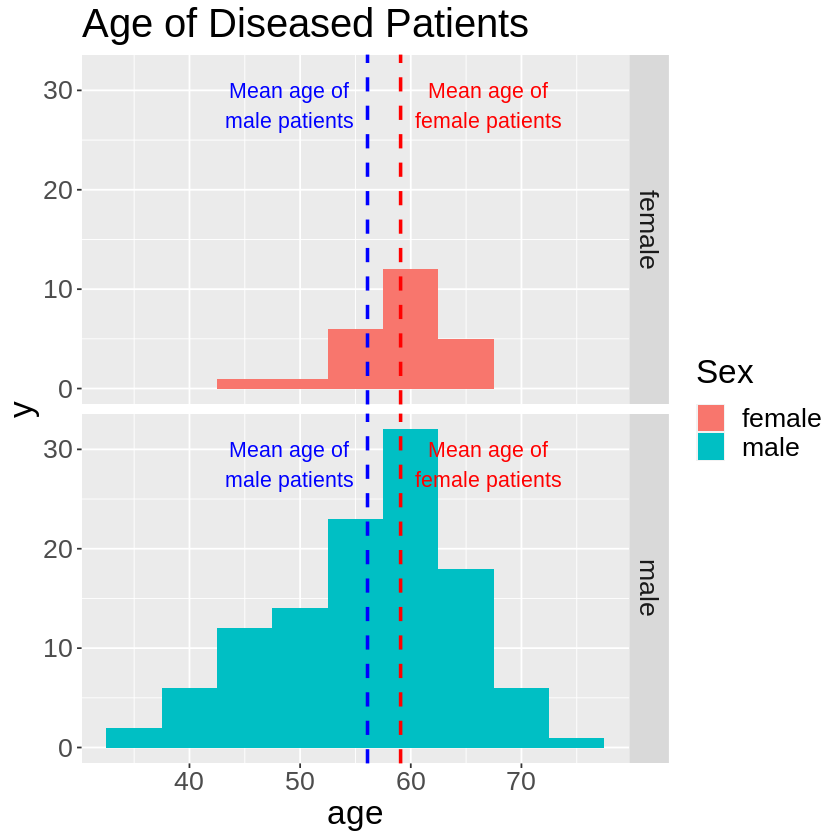

In [35]:
# plot raw data

# Both male and female patients
age_plot <- diseased %>%
    ggplot(aes(x = age, fill = sex)) +
    geom_histogram(binwidth = 5) +
    facet_grid(rows = vars(sex)) +
    geom_vline(xintercept = mean_age_male, linetype = "dashed", size = 1, color = "blue") + # mean age of male patients
    geom_vline(xintercept = mean_age_female, linetype = "dashed", size = 1, color = "red") + # mean age of female patients
    labs(title = "Age of Diseased Patients",
         xlab = "Age",
         fill = "Sex") +
    annotate("text", x = 67, y = 30, label = "Mean age of", color="red", size=4.5) +
    annotate("text", x = 67, y = 27, label = "female patients", color="red", size=4.5) +
    annotate("text", x = 49, y = 30, label = "Mean age of", color="blue", size=4.5) +
    annotate("text", x = 49, y = 27, label = "male patients", color="blue", size=4.5) +
    theme(text = element_text(size = 20))

age_plot

### Inferential Analysis

#### Bootstrapping:

replicate,stat,samp_dist
<int>,<dbl>,<chr>
1,3.6946387,Actual
2,2.9957265,Actual
3,3.2270175,Actual
4,0.4907895,Actual
5,2.6941138,Actual
6,3.8043478,Actual


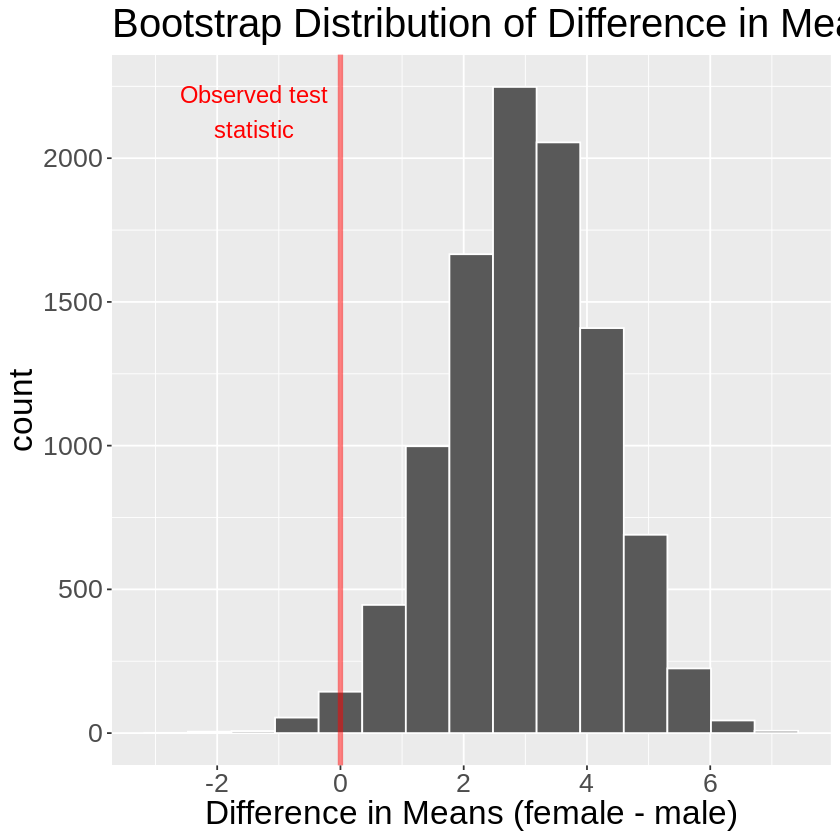

In [41]:
# Data resampling, calculation of difference in means & visualization
# Infer package is used to simplify process

# Boostrap Generated
age_bootstrap <- diseased %>%
    specify(formula = age ~ sex) %>% # specify response and explanatory variables
    generate(reps = 10000, type = "bootstrap") %>% # generate bootstraps
    calculate(stat = "diff in means", order = c("female", "male")) %>% # calculate difference in means
    mutate(samp_dist = "Actual")
head(age_bootstrap) # show bootstraps

# Summary Statistics Calculated, Visualized
age_bootstrap_vis <- age_bootstrap %>%
    visualize() + 
    xlab("Difference in Means (female - male)")+
    ggtitle("Bootstrap Distribution of Difference in Mean") +
    geom_vline(xintercept = 0, colour = "red", lwd = 1.5, alpha = 0.5) + # null hypothesis
    annotate("text", x = -1.4, y = 2222, label = "Observed test", color="red", size=5) +
    annotate("text", x = -1.4, y = 2100, label = "statistic", color="red", size=5) +
    theme(text = element_text(size = 20)) 
age_bootstrap_vis

#### Hypothesis Testing:

Previous research suggests that there is likely a difference in the mean age at which men and women suffer from CVDs, with men being afflicted earlier in their lives. Consequently, we have selected our hypothesis as:

H0: $\mu$female - $\mu$male = 0



H1: $\mu$female - $\mu$male > 0

Moreover, we are setting our significance level (p-value) to:

$\alpha$ = 0.05

...(further explanation/reasoning)

In [42]:
# Hypothesis testing via Infer package

#observed test statistic
obs_diff_means <- diseased %>%
    specify(formula = age ~ sex) %>% #set response and explanatory variables
    calculate(stat = "diff in means", order = c("female", "male")) %>% #set intended test statistic
    pull()

Figure #. Observed Difference in Means in Data

|Test Statistic|
|-----|
|2.99228070175438|

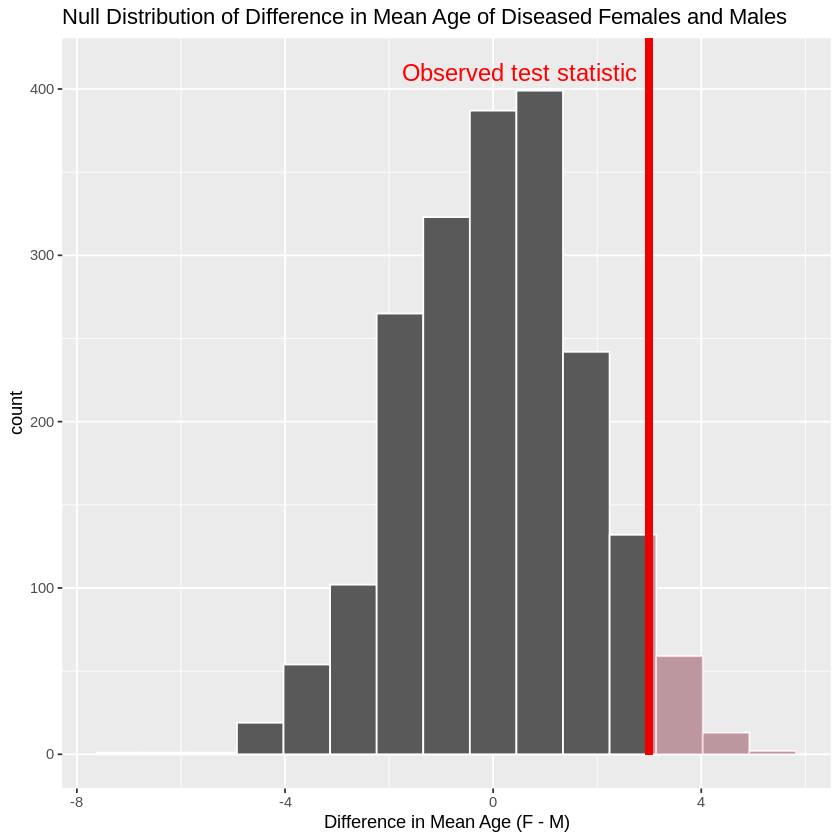

In [43]:
#generation of null distribution
age_null <- diseased %>%
    specify(formula = age ~ sex) %>% #set response and explanatory variables
    hypothesize(null = "independence") %>% #set hypothesis type
    generate(reps = 2000, type = "permute") %>% #generate replicates via permutation
    calculate(stat = "diff in means", order = c("female", "male")) %>% #set intended test statistic
    mutate(samp_dist = "Null Model")

visualize(age_null) + 
    shade_p_value(obs_stat = obs_diff_means, direction = "right") +
    ggtitle("Null Distribution of Difference in Mean Age of Diseased Females and Males") +
    xlab("Difference in Mean Age (F - M)") +
    annotate("text", x = 0.5, y = 410, label = "Observed test statistic", color="red", size=5) +
    theme(text = element_text(size = 11))

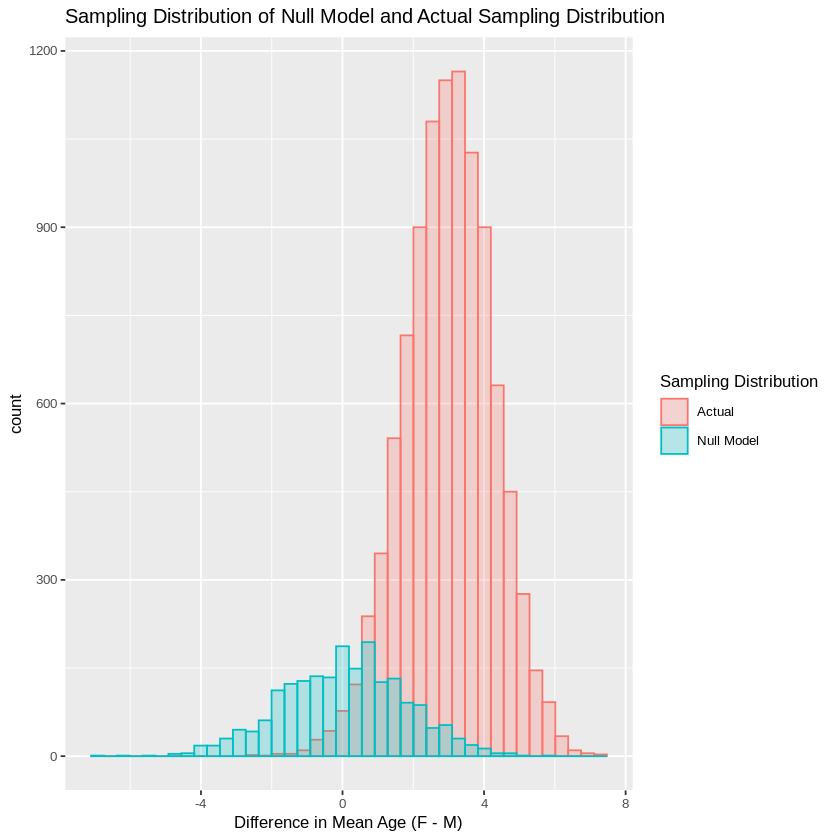

In [44]:
# Constrasting the null model and the actual sampling distribution
null_actual_samp_dist <- age_bootstrap %>% 
    bind_rows(age_null) %>% 
    ggplot() + 
    geom_histogram(aes(stat, color=samp_dist, fill=samp_dist), alpha=.25, bins=40, position="identity" ) +
    theme(text = element_text(size=20)) + 
    labs(title = "Sampling Distribution of Null Model and Actual Sampling Distribution", 
         x = "Difference in Mean Age (F - M)",
         fill = "Sampling Distribution",
         color = "Sampling Distribution") +
    theme(text = element_text(size = 10))

null_actual_samp_dist

In [45]:
#p-value extraction
p_value <- age_null %>%
    get_p_value(obs_stat = obs_diff_means, direction = "right")

Figure #. Calculated P-Value 
|P-Value|
|-------|
|0.0385 |

#### Constructing 95% Confidence Interval

In [46]:
bootstrap_ci <- get_ci(age_bootstrap, level = 0.95) #extraction of 95% CI using Infer Package


Figure #. 95% Confidence Interval based on Bootstrap Distribution

|Lower Bound|Upper Bound|
|----|----|
|0.4600096|5.339402|


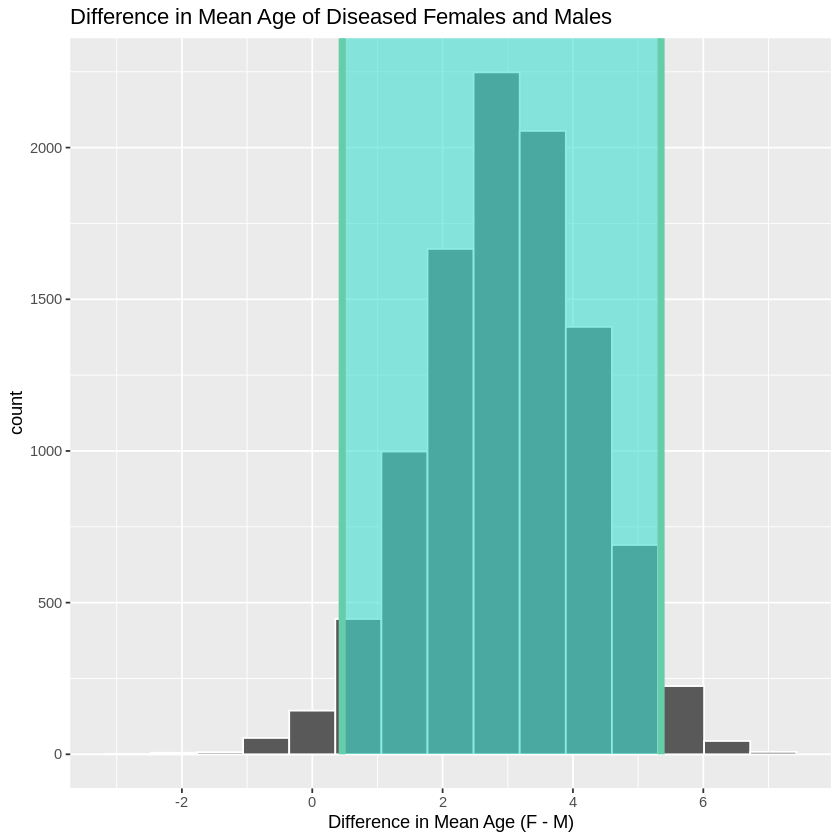

In [47]:
#CI Visualization

visualize(age_bootstrap) +
    shade_confidence_interval(endpoints = bootstrap_ci) +
    xlab("Difference in Mean Age (F - M)") +
    ggtitle("Difference in Mean Age of Diseased Females and Males") 


### Methods

Based on preliminary findings of our estimates and histogram, we can already see a difference in average age between both sexes which supports our previous research.

The histogram and estimates we produced above display the mean ages for male and female patients from the data respectively. However, our data set only encompasses cardiovascular disease patients from the Cleveland data, which cannot accurately represent Canada, the population of interest. Given that the Cleveland data is only one sample of data and there is a notable difference in sample size in male and female patients, with the Cleveland data as our sample, we can perform the bootstrap method to estimate average age of male and female patients in Canada (population parameter) as bootstrap samples many times. We will also look at the standard deviation for each sex to quantify the variability in mean ages. To answer our research question, we will perform a one-sided hypothesis test; calculating the p-value from our bootstrap sample. Based on previous research, we will perform a one-sided hypothesis test where the null hypothesis being that the mean ages are the same between sexes and the alternative hypothesis being that the mean age of men suffering from CVDs is lower than that of women. Given from our hypothesis test, we will be able to determine if the results support the claims of previous research. We will also calculate the confidence intervals to get a range of where our population mean is likely within. This will help us find an estimate of our population from our sample data of Cleveland patients. 

Based on previous studies and preliminary analysis of the data, we expect to find a statistically significant difference in the mean age of men and women suffering from CVDs, with the age of men being lower than that of women (Mosca et al., 2011). It is our hope that understanding the average age of men and women suffering from CVDs and standard deviation will contribute to more informed diagnoses for patients. Moreover, these findings, along with further research into female-specific risk factors and disease mitigation, could help shape clinical practice and improve disease outcomes for women.

### References

Mosca, L., Barrett-Connor, E., & Wenger, N. K. (2011). Sex/gender differences in cardiovascular disease prevention: What a difference a decade makes. Circulation, 124(19), 2145–2154. https://doi.org/10.1161/CIRCULATIONAHA.110.968792

Public Health Agency (P.H.A) of Canada. (2017, February 10). Heart Disease in Canada. Canada.ca. Retrieved July 26, 2022, from https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html

Solé-Auró, A., Michaud, P.-C., Hurd, M., & Crimmins, E. (2015). Disease Incidence and Mortality Among Older Americans and Europeans. Demography, 52(2), 593–611. https://doi.org/10.1007/s13524-015-0372-7

Statistics Canada. (2022). Leading causes of death, total population, by age group [Data set]. Government of Canada. https://doi.org/10.25318/1310039401-ENG